In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk
nltk.download('punkt')

from bertopic import BERTopic
from bertopic.representation import BaseRepresentation
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN



csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/english/dreamachine/HS_reflections_cleaned.csv'
df = pd.read_csv(csv_path, quoting=3, on_bad_lines='skip')
df

[nltk_data] Downloading package punkt to /Users/rbeaute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,reflection_answer
0,Intense chaos. And then my mind checked out an...
1,"""good stuff."""
2,a pattern of red and white lights that flashed...
3,I went back to many hard and mostly beautiful ...
4,Hello
...,...
313,pleasure & intrigue
314,"""traveling through space"
315,""""
316,"""I thought a lot about Rand's journey into Rhu..."


In [20]:
df['reflection_answer'] = df['reflection_answer'].str.replace('"', '', regex=False) # Remove quotes 
# df = df[df['reflection_answer'].str.split().str.len() > 1] # delete lines that have only one word
df.reset_index(drop=True, inplace=True)
df

,reflection_answer
0,Intense chaos. And then my mind checked out an...
1,good stuff.
2,a pattern of red and white lights that flashed...
3,I went back to many hard and mostly beautiful ...
4,Hello
...,...
313,pleasure & intrigue
314,traveling through space
315,
316,I thought a lot about Rand's journey into Rhui...


In [ ]:


# ----------------------------------------
reports = df['reflection_answer'].tolist()
print(f"Loaded {len(reports)} (translated) documents for BERTopic modeling.")
# ----------------------------------------

# ----------------------------------------
# Divide each report into sentences
reports_sentences = [nltk.sent_tokenize(report) for report in reports]

sentences = [sentence for report in reports_sentences for sentence in report]
print(f"Total number of sentences across all reports: {len(sentences)}")
# ----------------------------------------

# filter sentences by min length
min_word_count = 2
sentences = [s for s in sentences if len(s.split()) >= min_word_count]
print(f"Total number of sentences after filtering by length: {len(sentences)}")

docs = sentences

Loaded 318 (translated) documents for BERTopic modeling.
Total number of sentences across all reports: 404
Total number of sentences after filtering by length: 368


In [24]:
sentences

['Intense chaos.',
 'And then my mind checked out and my subconscious took over and started talking.',
 "What I imagine it's like looking back on life before you die.",
 'good stuff.',
 'a pattern of red and white lights that flashed and became more intense when the lights flashed intensely.',
 'I also felt sleepy for a bit and I was thinking of my partner who I could visualize',
 'I went back to many hard and mostly beautiful memories without prompting them at all.',
 'Hope as a color',
 'dreaming while awake- flashes of random places I have been.',
 "maybe this is what it's like to be dead.",
 'Being: immersed; calm; and thrilled.',
 'life after retirement',
 'Personally it was hard for me to find peace with the intensity of the bright light.',
 "My eyes wouldn't stop watering so that kept my mind occupied.",
 'Still a really cool experience!',
 'was like taking hallucinogenic drugs when I was younger',
 "the closest thing I'll ever experience to being on drugs",
 'Incredible technic

In [25]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [26]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename) #, cache_dir=path)


# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, 
            n_gpu_layers=-1, #offload all possible layers of the model to the GPU
            n_ctx=4096, 
            stop=["Q:", "\n"],
            verbose=False)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [27]:
prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
embeddings = embedding_model.encode(docs, show_progress_bar=True)


# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')




# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [28]:
topic_model = BERTopic(
 # Sub-models
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 representation_model=representation_model,
 vectorizer_model=vectorizer,
 nr_topics="auto",  # Automatically determine the number of topics

 # Hyperparameters
 top_n_words=10,
 verbose=True
)


# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


# Show topics
topic_model.get_topic_info()

2025-06-24 12:34:10,675 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-24 12:34:11,151 - BERTopic - Dimensionality - Completed ✓
2025-06-24 12:34:11,152 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-24 12:34:11,166 - BERTopic - Cluster - Completed ✓
2025-06-24 12:34:11,166 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-24 12:34:11,182 - BERTopic - Representation - Completed ✓
2025-06-24 12:34:11,183 - BERTopic - Topic reduction - Reducing number of topics
2025-06-24 12:34:11,186 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 3/3 [00:10<00:00,  3.36s/it]
2025-06-24 12:34:22,331 - BERTopic - Representation - Completed ✓
2025-06-24 12:34:22,333 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,164,-1_like_experience_space_music,"[like, experience, space, music, saw, body, fe...","[felt like, kept seeing, amazing experience, f...","[""Vibrant Space and Cosmic Experience"", , , , ...",[felt out of my body - in fact off planet Eart...
1,0,143,0_felt_experience_sense_like,"[felt, experience, sense, like, thoughts, peac...","[experience felt, felt overwhelming, felt rela...","[""Personal Spiritual Growth Experience"", , , ,...",[I felt deep connection with humankind and an ...
2,1,61,1_colors_patterns_shapes_kaleidoscope,"[colors, patterns, shapes, kaleidoscope, image...","[lights, lights colors, patterns lights, patte...","[""Vibrant Light and Color Patterns"", , , , , ,...",[a pattern of red and white lights that flashe...


In [29]:
topic_model.visualize_documents(docs, 
                                reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, 
                                hide_document_hover=False, 
                                custom_labels=True)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct`'}>)

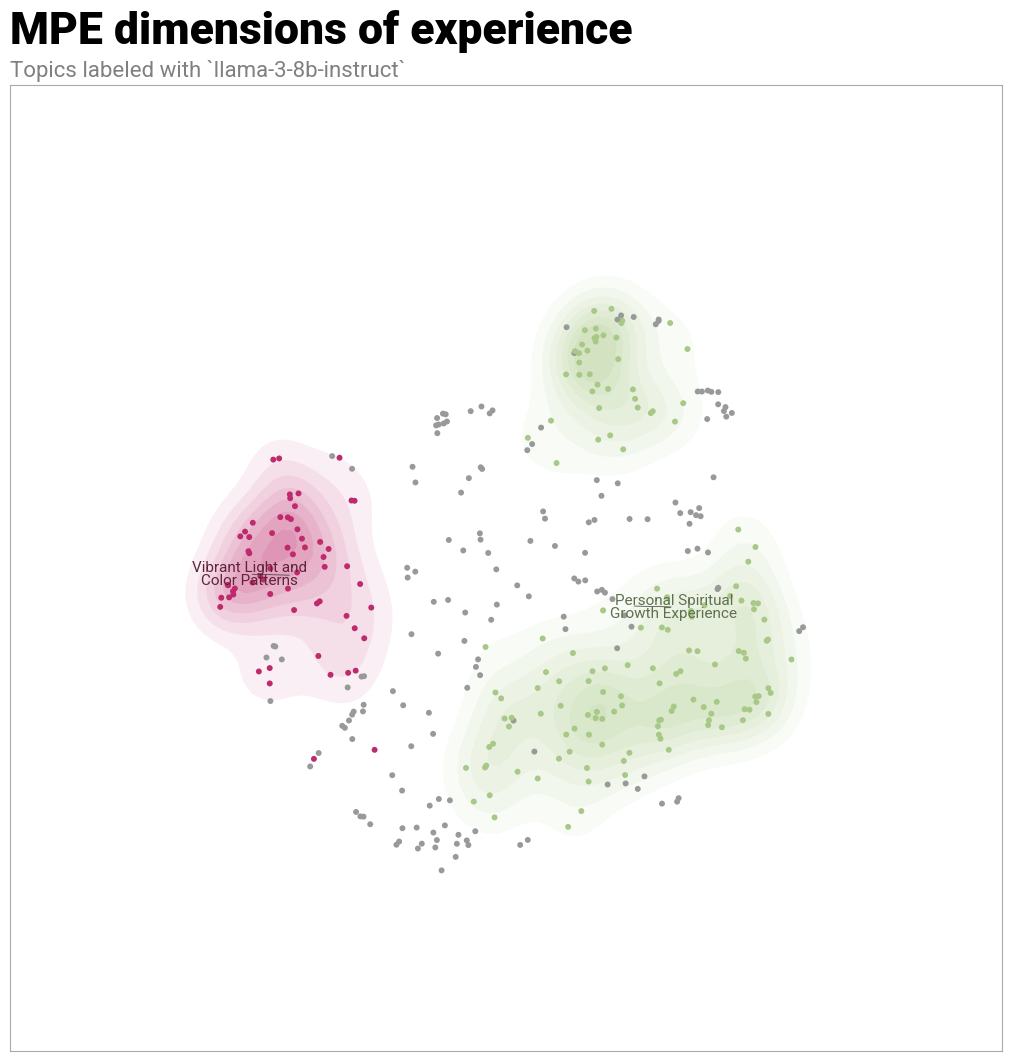

In [30]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title="MPE dimensions of experience",
   sub_title="Topics labeled with `llama-3-8b-instruct`",
   label_wrap_width=20
)

In [34]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.9)
hierarchy_vis